# Restaurant Recommender

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-in-cleaned-data" data-toc-modified-id="Read-in-cleaned-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read in cleaned data</a></span><ul class="toc-item"><li><span><a href="#Split-train-and-test" data-toc-modified-id="Split-train-and-test-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Split train and test</a></span></li></ul></li><li><span><a href="#Initialise-and-fit-the-recommender-class" data-toc-modified-id="Initialise-and-fit-the-recommender-class-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initialise and fit the recommender class</a></span></li><li><span><a href="#Comparison-to-naive-recommender" data-toc-modified-id="Comparison-to-naive-recommender-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparison to naive recommender</a></span></li><li><span><a href="#Recommendations" data-toc-modified-id="Recommendations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Recommendations</a></span><ul class="toc-item"><li><span><a href="#Recommend-restaurants-similar-to-a-given-restaurant" data-toc-modified-id="Recommend-restaurants-similar-to-a-given-restaurant-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Recommend restaurants similar to a given restaurant</a></span></li><li><span><a href="#Recommend-20-restaurants-for-a-given-user" data-toc-modified-id="Recommend-20-restaurants-for-a-given-user-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Recommend 20 restaurants for a given user</a></span></li><li><span><a href="#Recommend-top-20-restaurants-in-Toronto" data-toc-modified-id="Recommend-top-20-restaurants-in-Toronto-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Recommend top 20 restaurants in Toronto</a></span></li></ul></li><li><span><a href="#Brief-grid-search-for-k,-iter-and-learning-rate" data-toc-modified-id="Brief-grid-search-for-k,-iter-and-learning-rate-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Brief grid search for k, iter and learning rate</a></span></li><li><span><a href="#Conclusion-and-next-steps" data-toc-modified-id="Conclusion-and-next-steps-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion and next steps</a></span><ul class="toc-item"><li><span><a href="#Closing-thoughts" data-toc-modified-id="Closing-thoughts-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Closing thoughts</a></span></li><li><span><a href="#Next-steps" data-toc-modified-id="Next-steps-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Next steps</a></span></li></ul></li></ul></div>

## Read in cleaned data

In [1]:
import pandas as pd
import numpy as np
import recommender  ## Custom built FunkSVD recommender class
from numba import jit
import time

In [2]:
toronto_reviews_sub = pd.read_json('data/toronto_reviews_sub.json', orient='records')
df_businesses_toronto = pd.read_json('data/businesses_toronto.json', orient='records')

### Split train and test
We time-order the review data to split for train and test, this means that the model isn't predicting past reviews based on future data.  This more closely reflects the use-case of using a user's historic review data to predict future reviews.

In [3]:
toronto_reviews_train = toronto_reviews_sub[toronto_reviews_sub.year <2019]
toronto_reviews_test = toronto_reviews_sub[toronto_reviews_sub.year == 2019]

Drop all but the most recent review from each user for each restaurant - thinking being that their most recent review will affect their future behaviour more

In [4]:
print('Before, # reviews: ',len(toronto_reviews_train))
toronto_reviews_train = toronto_reviews_train[~toronto_reviews_train.duplicated(subset=['user_id','business_id'],keep='last')]
print('After,  # reviews: ', len(toronto_reviews_train))


Before, # reviews:  17941
After,  # reviews:  17157


Create user_by_restaurant table

In [5]:
toronto_reviews_train.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,city,year
0,0bG4SvQx1-YQf8S5vi-JXQ,foCj2hDfH84WGwglfAbDVA,4m_hApwQ054v3ue_OxFmGw,3,1,0,0,2016-11-09,Toronto,2016
1,F-rEm9n8EsMCDrKuac1LEw,DTl0SQ_9ApT_YhIcppwqgw,4m_hApwQ054v3ue_OxFmGw,4,0,0,0,2015-07-04,Toronto,2015
2,uOpzjADQ_b50ZuRlnQ-j3w,JLvoH5EfNResDJBeQUIqCA,4m_hApwQ054v3ue_OxFmGw,3,0,0,1,2016-10-01,Toronto,2016
3,BTnPU97pFs6MaeF9IOea2A,gGtM52jNBzsP_sGCSIRz0A,4m_hApwQ054v3ue_OxFmGw,4,0,0,0,2017-08-29,Toronto,2017
4,WsPA489NRqoTd2CZiOACmw,X-VOe5bzT9EJu_L_Bt0nLQ,4m_hApwQ054v3ue_OxFmGw,5,1,0,0,2015-02-24,Toronto,2015


## Initialise and fit the recommender class

Note this class has a `.fit()` method which uses the `Numba` library.  This one change (numba-ising) the fit method, increased the excecution speed of the fitting by **~400X**.  Without this, grid searching for better fit parameters would have been impractical.

In [6]:
rec = recommender.Recommender()
# Create the user-rx matrix
rec.set_user_item_matrix(toronto_reviews_train,'user_id','business_id','stars')

Min rating: 1, max rating: 5


*Due to the fit method being Numba-ised, the fit method will error the first time it it run.  To get round this, we run it once with the Try statement and then a second time with the Except.  Subsequent runs do not need this precaution.*

In [7]:
# Fit the FunkSVD - this will create a warning about contiguous arrays which can be ignored

try:
    rec.fit(latent_features=10, learning_rate=0.005, iters=25, print_every = 5)
except:
    rec.fit(latent_features=10, learning_rate=0.005, iters=25, print_every = 5)
    

/Users/paulgstubley/Code/GitHub/Udacity/Capstone_Project/recommender.py:50: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  err = ratings_mat[u,m]-np.dot(user_mat[u,:],item_mat[:,m])


Optimization Statistics
Iterations	| Mean Squared Error	
5 		| 0.00715
10 		| 0.00584
15 		| 0.00499
20 		| 0.00426
25 		| 0.00363


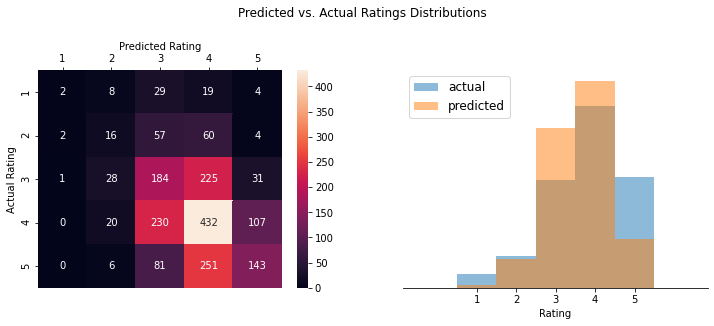

In [8]:
# How did we do?
# Compare predicted ratings to test ratings
confusion_array, SSE = rec.compare_train_to_predictions(toronto_reviews_test)

## Comparison to naive recommender
To see whether this FunkSVD recommender is better than just recommending for everyone based on the average-rating of each restaurant, we compare to predicted ratings which are precisely that - for every user their predicted rating is simply the average rating for that business.

business_id,--DaPTJW3-tB1vP-PfdTEg,--SrzpvFLwP_YFwB_Cetow,-0aOudcaAyac0VJbMX-L1g,-6mzdR0YjOToJ8E04Y9O0Q,-BVqCPibTNPCNeT0uJsiRg,-CLTZ0cO-ooKDDmXHFoGMg,-ClafaRWkSRTfieIzO4r3Q,-HwprJh-Bve1pcDH8_UFeQ,-IXNFjtECsn8fqF047tYFw,-OxDX2fPQLYi6ChW2Z6xxQ,...,zeiaHxtK2fTUz_jlPdIKPQ,ziLoZvl1mEuDYlndTezRZw,ziiVVWwlQbvk6fqvPt-RsA,zm7e0hmW4aPvoRsAdqqEyA,zqPAwZbi5rS1dyHrKzDpMg,zrYpLdnGKA_EmOhgRCy_vg,zvtkeghW0Px5HY9QkJ4INw,zwGu5H7MnilB9Fw7DZ7kXQ,zy_NHTqtfSrfTGGPoqy4Mw,zzH3E5DA8eMzFwv2k5izyw
user_id,,,,,,,,,,,,,,,,,,,,,
--BumyUHiO_7YsHurb9Hkw,3.5,3.272727,4.0,4.0,4.0,4.0625,3.0,5.0,3.692308,3.666667,...,3.466667,5.0,5.0,2.8,3.333333,4.090909,3.5,1.0,3.0,4.0
--Qh8yKWAvIP4V4K8ZPfHA,3.5,3.272727,4.0,4.0,4.0,4.0625,3.0,5.0,3.692308,3.666667,...,3.466667,5.0,5.0,2.8,3.333333,4.090909,3.5,1.0,3.0,4.0
-3PTUP443q6hQESLKSu95w,3.5,3.272727,4.0,4.0,4.0,4.0625,3.0,5.0,3.692308,3.666667,...,3.466667,5.0,5.0,2.8,3.333333,4.090909,3.5,1.0,3.0,4.0
-9RU4LuI_TfYgv9rBijJoQ,3.5,3.272727,4.0,4.0,4.0,4.0625,3.0,5.0,3.692308,3.666667,...,3.466667,5.0,5.0,2.8,3.333333,4.090909,3.5,1.0,3.0,4.0
-ILapEusonY1QHyJPvUk2A,3.5,3.272727,4.0,4.0,4.0,4.0625,3.0,5.0,3.692308,3.666667,...,3.466667,5.0,5.0,2.8,3.333333,4.090909,3.5,1.0,3.0,4.0


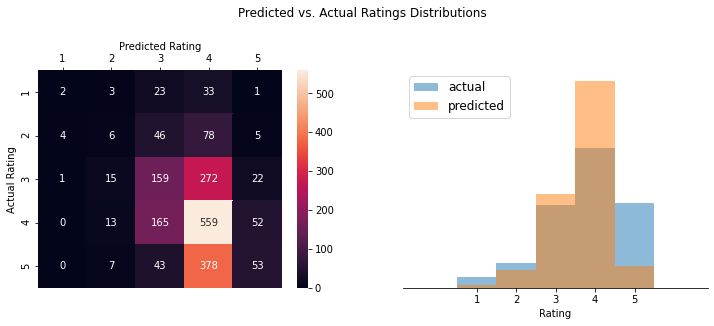

In [9]:
column_means = rec.ratings_mat.mean(axis=0)
alt_ratings_mat_pred= rec.ratings_mat.apply(lambda x: column_means, axis=1)
conf, SSE_alt = rec.compare_train_to_predictions(toronto_reviews_test,alt_ratings_mat_pred)
alt_ratings_mat_pred.head()

In [10]:
print('Error-score for FunkSVD based recommender: {:0.2f} , naive recommender: {:0.2f}'.format(SSE,SSE_alt))

Error-score for FunkSVD based recommender: 1989.09 , naive recommender: 1924.52


At this stage the naive recommender is slightly better, however later we grid-search the FunkSVD fit parameters.

## Recommendations
### Recommend restaurants similar to a given restaurant
***Note that each output chart has info-tooltips if you click on a given point***

In [11]:
out = rec.get_similar_items('U0md3UhNA2123G-vYR9hWQ',20)
recoms = rec.get_item_names(df_businesses_toronto, out, 'name', ['similarity','latitude', 'longitude', 'review_count'])
m = rec.plot_locations(recoms, 'name', 'latitude', 'longitude',info=None, search_string='toronto' )
m

### Recommend 20 restaurants for a given user

In [12]:
series = rec.predict_ratings_for_user('Kj9cFO70zZOQorN0mgeLWA', 20)
recoms = rec.get_item_names(df_businesses_toronto, series, 'name', ['predicted_rating','latitude', 'longitude', 'review_count'])
m = rec.plot_locations(recoms, 'name', 'latitude', 'longitude', info='predicted_rating',search_string='toronto' )
m.save('map.html')
m

### Recommend top 20 restaurants in Toronto
For users with too few reviews to be included in the model, we can recommend generic top-n lists

In [13]:
# For users who don't have enough reviews to be included in the FunkSVD
# Plot the top 30 restaurants with at least 20 reviews
top_rx = rec.get_item_names(df_businesses_toronto, rec.get_top_reviewed_items(20)[:30], 'name', ['latitude', 'longitude', 'Avg rating'])
rec.plot_locations(top_rx, 'name','latitude','longitude', search_string = 'toronto', info = 'Avg rating')


## Brief grid search for k, iter and learning rate

**NB Too-fast a learning rate results in a divergent fit, for example a `rate` of 0.05 resulted in yielding all NaNs as predictions.**

In [14]:
for rate in [0.005,0.001,0.0005,0.0001,0.00005]:
    for k in [10,25,50]:
        for iters in [100,250,500]:
            rec.fit(latent_features=k, learning_rate=rate, iters=iters)
            _, SSE = rec.compare_train_to_predictions(toronto_reviews_test, plot=False)
            print('LF: {} \t|LR: {} \t|iters: {} \t| SSE: {}'.format(k, rate, iters, SSE))

/Users/paulgstubley/Code/GitHub/Udacity/Capstone_Project/recommender.py:50: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  err = ratings_mat[u,m]-np.dot(user_mat[u,:],item_mat[:,m])


LF: 10 	|LR: 0.005 	|iters: 100 	| SSE: 2678.1764540264808
LF: 10 	|LR: 0.005 	|iters: 250 	| SSE: 3167.6857044397184
LF: 10 	|LR: 0.005 	|iters: 500 	| SSE: 3352.7438423120548
LF: 25 	|LR: 0.005 	|iters: 100 	| SSE: 2582.4460437342864
LF: 25 	|LR: 0.005 	|iters: 250 	| SSE: 2611.9298208504624
LF: 25 	|LR: 0.005 	|iters: 500 	| SSE: 2650.8366279038664
LF: 50 	|LR: 0.005 	|iters: 100 	| SSE: 3065.7109965779764
LF: 50 	|LR: 0.005 	|iters: 250 	| SSE: 2939.0639152540853
LF: 50 	|LR: 0.005 	|iters: 500 	| SSE: 3047.3861504995984
LF: 10 	|LR: 0.001 	|iters: 100 	| SSE: 1941.7445626244225
LF: 10 	|LR: 0.001 	|iters: 250 	| SSE: 2237.0158418577457
LF: 10 	|LR: 0.001 	|iters: 500 	| SSE: 2668.795826218981
LF: 25 	|LR: 0.001 	|iters: 100 	| SSE: 2179.6355128870437
LF: 25 	|LR: 0.001 	|iters: 250 	| SSE: 2479.800008405039
LF: 25 	|LR: 0.001 	|iters: 500 	| SSE: 2623.4396601090175
LF: 50 	|LR: 0.001 	|iters: 100 	| SSE: 2811.1226560211553
LF: 50 	|LR: 0.001 	|iters: 250 	| SSE: 3027.274738966197


It looks like overfitting is an issue as the number of iterations increases for each set of learning-rate and latent-features.  However, we can see that certain combinations are a (slight) improvement over our naive recommender SSE of ~1900.  We investigate a more focussed grid area below to attempt a better test-score.

In [ ]:
for rate in [0.0001, 0.00005,0.00001]:
    for k in [10]:
        for iters in [500,1000,2500,5000]:
            rec.fit(latent_features=k, learning_rate=rate, iters=iters)
            _, SSE = rec.compare_train_to_predictions(toronto_reviews_test, plot=False)
            print('LF: {} \t|LR: {} \t|iters: {} \t| SSE: {}'.format(k, rate, iters, SSE))
            
            

LF: 10 	|LR: 0.0001 	|iters: 500 	| SSE: 1886.2432280684027
LF: 10 	|LR: 0.0001 	|iters: 1000 	| SSE: 1918.8706243370316


Therefore we recommend using the parameters:
    - LF = 10
    - LR = 1E-4
    - iters = 1000
    
This is informaed as a mix of low error score and execution time

This takes us from a SSE of ~ 1976 to ~1859 (improving over the naive recommender at ~1924).

We could use a k-folds method to understand the effect of adjusting these model parameters more.

## Conclusion and next steps

### Closing thoughts

It appears a FunkSVD model fitted to the train data can predict ratings marginally better than a naive average-of-past-ratings predictor.  We can see from the histogram in [Section 2](#Initialise-and-fit-the-recommender-class) above, that the skew of the training data (i.e. far more high ratings than low) is causing an issue with prediction.  In addition, though related, is that the imbalance towards high ratings affect the accuracy of low-rating predictions (as the model has far few to learn from).  Addressing both the issues of imbalance and skew are areas of active research in the literature.

One feature that opened up this project fully was moving to a `Numba` function for the fit.  Without this change, grid-searching hyper-parameters would have been prohibitively time-consuming. 

### Next steps

To improve usefulness to an end application two further features of the class could be created to bring in knowledge-based recommendation techniques:

- Allow filtering by proximity to a certain point (e.g. a user's location)
    - This could be addressed using `geopandas` buffers
- Allow filtering by cuisine.
    - There are additional category flags in the business data set that would allow filtering by cuisine type.
    
To further investigate this theme, I would also look at how my decision in the Data Cleaning step to bring forward all users with at least 10 ratings affected the outcome.  Do the results change if we a more/less stringent with this filter?
